In [1]:
import os
import time
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision

# Подготовка данных для обучения
Выгружаем из датасета данные по трем языкам, которые будем идентефицировать (Русский, Английский, Немецкий)

In [2]:
lang_dict = {
    "ru": "ru-RU",
    "en": "en-US",
    "de": "de-DE",
}

def get_ds_splits(lang: str = "ru"):
    ds = load_dataset("PolyAI/minds14", lang_dict[lang])
    train_test_ds = ds["train"].train_test_split(test_size=0.2, seed=42, shuffle=True)
    test_val_ds = train_test_ds["test"].train_test_split(test_size=0.5, seed=42, shuffle=True)

    return DatasetDict({
    'train': train_test_ds['train'],
    'valid': test_val_ds['train'],
    'test': test_val_ds['test']
    })


In [3]:
ds_splits_ru = get_ds_splits(lang="ru")
ds_splits_en = get_ds_splits(lang="en")
ds_splits_de = get_ds_splits(lang="de")

Функции для предобработки данных
- Сохранение аудиозаписи 
- Сохранение транскрипции по аудиозаписи
- Построение и сохранение спектрограммы

In [4]:
current_dir = os.getcwd()

def check_exists_path(path):
    if not os.path.exists(path):
        os.makedirs(f"{current_dir}/{path}")

In [5]:
def save_audio(y, sr, path, name):
    check_exists_path(path=path)
    sf.write(file=f"{path}/{name}.wav", data=y, samplerate=sr, subtype="PCM_16")

In [6]:
def save_transcription(transcription, path, name):
    check_exists_path(path=path)
    with open(f"{path}/{name}.txt", "w", encoding="utf-8") as file:
            file.write(transcription)

In [7]:
def save_spectrogram_image(y, sr, path, name):
    check_exists_path(path=path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S)
    plt.figure(figsize=(1,1))
    librosa.display.specshow(log_S, sr=sr)
    plt.savefig(f"{path}/{name}.png")
    plt.close()

In [8]:
def save_data(ds, split: str = "train", lang: str = "ru"):
    audio_path = f"data/{split}_audio/{lang}"
    transcription_path = f"data/{split}_transcription/{lang}"
    spectrogram_path = f"data/{split}_spectrogram/{lang}"


    for idx, item in tqdm(enumerate(ds[f"{split}"])):
        y = item["audio"]["array"]
        sr = item["audio"]["sampling_rate"]
        transcription = item["transcription"]
        name = f"{lang}_{split}_{idx}"

        # Сохраняем аудио
        save_audio(y=y, sr=sr, path=audio_path, name=name)

        # Сохраняем транскрипцию
        save_transcription(transcription=transcription, path=transcription_path, name=name)

        # Сохраняем спектрограмму
        save_spectrogram_image(y=y, sr=sr, path=spectrogram_path, name=name)

In [9]:
save_data(ds=ds_splits_ru, split="train", lang="ru")
save_data(ds=ds_splits_ru, split="valid", lang="ru")
save_data(ds=ds_splits_ru, split="test", lang="ru")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
save_data(ds=ds_splits_en, split="train", lang="en")
save_data(ds=ds_splits_en, split="valid", lang="en")
save_data(ds=ds_splits_en, split="test", lang="en")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [11]:
save_data(ds=ds_splits_de, split="train", lang="de")
save_data(ds=ds_splits_de, split="valid", lang="de")
save_data(ds=ds_splits_de, split="test", lang="de")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Обучение модели Language Identification

In [12]:
def load_dataset(split: str = "train"):
    data_path = f"data/{split}_spectrogram"
    dataset = torchvision.datasets.ImageFolder(root=data_path, transform=torchvision.transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=0, shuffle=True)
    return loader, dataset

train_loader, _ = load_dataset(split="train")
valid_loader, valid_dataset = load_dataset(split="valid")
test_loader, test_dataset = load_dataset(split="test")

In [13]:
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.fc1 = nn.Linear(18432, 1000)
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs_count = 30
count_batches = len(train_loader)

train_loss_step_history = []
train_accuracy_step_history = []

train_loss_epoch_history = []
train_accuracy_epoch_history = []

valid_loss_epoch_history = []
valid_accuracy_epoch_history = []

In [16]:
for epoch in range(0, epochs_count):
    correct_train, total_train, error_train = 0, 0, 0
    for idx, (images_train, labels_train) in enumerate(train_loader):

        outputs_train = model(images_train)
        error_train = loss(outputs_train, labels_train)
        train_loss_step_history.append(error_train.item())

        optimizer.zero_grad()
        error_train.backward()
        optimizer.step()

        total_train = labels_train.size(0)
        _, predicted_train = torch.max(outputs_train.data, 1)
        correct_train = (predicted_train == labels_train).sum().item()
        train_accuracy_step_history.append(correct_train / total_train * 100)

        correct_train += correct_train
        error_train += error_train
        total_train += total_train

        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
            epoch + 1,
            epochs_count,
            idx + 1,
            count_batches,
            error_train.item(),
            train_accuracy_step_history[-1],
        ))


    correct_valid, total_valid, error_valid = 0, 0, 0
    for idx, (images_valid, labels_valid) in enumerate(test_loader):

        outputs_valid = model(images_valid)
        error_valid = loss(outputs_valid, labels_valid)

        total_valid += labels_valid.size(0)
        _, predicted_valid = torch.max(outputs_valid.data, 1)
        correct_valid += (predicted_valid == labels_valid).sum().item()
        error_valid += error_valid

    valid_accuracy_epoch = correct_valid / total_valid * 100
    train_accuracy_epoch = correct_train / total_train * 100
    valid_loss_epoch = error_valid / total_valid
    train_loss_epoch = error_train / total_train

    valid_accuracy_epoch_history.append(valid_accuracy_epoch)
    train_accuracy_epoch_history.append(train_accuracy_epoch)
    valid_loss_epoch_history.append(valid_loss_epoch)
    train_loss_epoch_history.append(train_loss_epoch)

    flag = True
    for accuracy in valid_accuracy_epoch_history:
        if valid_accuracy_epoch_history[-1] < accuracy:
            flag = False

    if flag == True:
        model_path = "models/lid/"
        check_exists_path(model_path)

        named_tuple = time.localtime()
        time_string = time.strftime("%m-%d-%YT%H-%M-%S", named_tuple) 
        torch.save(model.state_dict(), f"{model_path}/CNNModel-date({time_string})-accuracy({valid_accuracy_epoch:.2f}).pth")
        print("Saved the updated model")  


    print('Valid Error: {} %'.format((valid_loss_epoch)))
    print('Valid Accuracy: {} %'.format(valid_accuracy_epoch))
    print('Train Error: {} %'.format((train_loss_epoch)))
    print('Train Accuracy: {} %'.format((train_accuracy_epoch)))


Epoch [1/30], Step [1/86], Loss: 2.2805, Accuracy: 37.50%
Epoch [1/30], Step [2/86], Loss: 197.3628, Accuracy: 50.00%
Epoch [1/30], Step [3/86], Loss: 136.4516, Accuracy: 31.25%
Epoch [1/30], Step [4/86], Loss: 50.1418, Accuracy: 37.50%
Epoch [1/30], Step [5/86], Loss: 31.2367, Accuracy: 25.00%
Epoch [1/30], Step [6/86], Loss: 25.6367, Accuracy: 50.00%
Epoch [1/30], Step [7/86], Loss: 32.3609, Accuracy: 37.50%
Epoch [1/30], Step [8/86], Loss: 15.1680, Accuracy: 31.25%
Epoch [1/30], Step [9/86], Loss: 37.5922, Accuracy: 37.50%
Epoch [1/30], Step [10/86], Loss: 11.1089, Accuracy: 43.75%
Epoch [1/30], Step [11/86], Loss: 10.7508, Accuracy: 31.25%
Epoch [1/30], Step [12/86], Loss: 29.4491, Accuracy: 37.50%
Epoch [1/30], Step [13/86], Loss: 15.0571, Accuracy: 37.50%
Epoch [1/30], Step [14/86], Loss: 21.1163, Accuracy: 31.25%
Epoch [1/30], Step [15/86], Loss: 11.7007, Accuracy: 50.00%
Epoch [1/30], Step [16/86], Loss: 14.1080, Accuracy: 25.00%
Epoch [1/30], Step [17/86], Loss: 4.1349, Accura

# Построение графиков с метриками

In [17]:
x = [i for i in range(1, epochs_count + 1)]

In [18]:
train_loss_epoch_history = [tensor.item() for tensor in train_loss_epoch_history]
valid_loss_epoch_history = [tensor.item() for tensor in valid_loss_epoch_history]

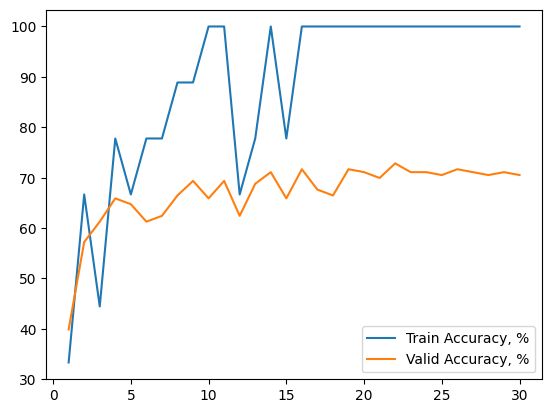

In [20]:
plt.plot(x, train_accuracy_epoch_history, label="Train Accuracy, %")
plt.plot(x, valid_accuracy_epoch_history, label="Valid Accuracy, %")
plt.legend()

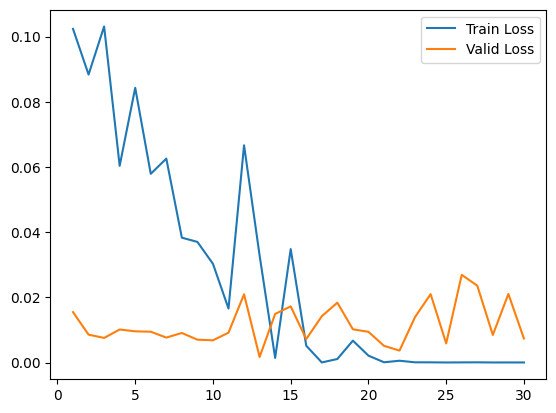

In [21]:
plt.plot(x, train_loss_epoch_history, label="Train Loss")
plt.plot(x, valid_loss_epoch_history, label="Valid Loss")
plt.legend()

Из графиков видно, что после 15 эпохи улучшения предсказательной способности модели почти не происходит.

# Проверка точности на тестовых данных

Загрузим модель, которая дала наилучший результат на валидационных данных и проверим результат на тестовых данных. Точность предсказания языка 72%

In [37]:
device = torch.device('cpu')
model = CNNModel()
model.load_state_dict(torch.load("models\lid\CNNModel-date(12-04-2023T19-16-00)-accuracy(72.83).pth", map_location=device))


correct_test, total_test, error_test = 0, 0, 0
for i, (images_test, labels_test) in enumerate(test_loader):
    outputs_test = model(images_test)
    error_test = loss(outputs_test, labels_test)
    _, predicted_test = torch.max(outputs_test.data, 1)
    total_test += labels_test.size(0)
    correct_test += (predicted_test == labels_test).sum().item()
    error_test += error_test
    
test_accuracy = (correct_test / total_test) * 100
print(test_accuracy)

72.25433526011561
